In [ ]:
!pip install Textacy

     |████████████████████████████████| 184kB 5.8MB/s 
     |████████████████████████████████| 481kB 30.5MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 1.9MB 34.9MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.0-cp36-cp36m-linux_x86_64.whl size=1225559 sha256=c4dcd183982d88019d907f7392f26a4a3e6a4808f7ef1e17c0775c4891f876b5
  Stored in directory: /root/.cache/pip/wheels/a1/32/3c/9c9926b510647cacdde744b2c7acdf1ccd5896fbb7f8d5df0c
Successfully built cytoolz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/SCOTUS/input-files/

/content/drive/MyDrive/SCOTUS/input-files


In [ ]:
import pickle, sys
import logging
from os import path
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import seaborn as sns
sns.set()
from sklearn.metrics import classification_report
from sklearn import preprocessing

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

import re
import pandas as pd
import textacy.datasets
import matplotlib.pyplot as plt
import numpy as np
import gensim
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def data_extraction():
    ds = textacy.datasets.SupremeCourt()
    ds.download()

    decisions = ds.records()
    scotus_issue_area = []
    scotus_issue = []
    scotus_text = []
    issue_freq = {}
    issue_area_freq = {}

    for text, details in decisions:
        if details['issue_area'] == -1:
            continue
        if details['issue'] == 'none':
            continue

        scotus_issue_area.append(details['issue_area'])
        scotus_issue.append(details['issue'])
        scotus_text.append(text)

        if details['issue'] in issue_freq:
            issue_freq[details['issue']] = issue_freq[details['issue']] + 1
        else:
            issue_freq[details['issue']] = 1

        if details['issue_area'] in issue_area_freq:
            issue_area_freq[details['issue_area']] = issue_area_freq[details['issue_area']] + 1
        else:
            issue_area_freq[details['issue_area']] = 1

    plot_issue_freq(issue_freq, issue_area_freq)
    return ds, decisions, scotus_issue_area, scotus_issue, scotus_text, issue_freq, issue_area_freq

In [ ]:
def generate_word_cloud(scotus_text):
    long_string = ','.join(str(scotus_text))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    image = wordcloud.to_image()
    image.save("full_word_cloud.png")

def plot_10_most_common_words(scotus_count_vector, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for word in scotus_count_vector:
        total_counts += word.toarray()[0]

    word_counts = (zip(words, total_counts))
    word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)[0:10]
    words = [w[0] for w in word_counts]
    counts = [w[1] for w in word_counts]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(10, 7))
    plt.subplot(title='Most common words')
    # sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.savefig('full_common_words.png')


def most_common_words(scotus_text):
    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english')
    # Fit and transform the processed titles
    scotus_text_df = pd.DataFrame(scotus_text)
    scotus_count_vector = count_vectorizer.fit_transform(scotus_text_df.astype('U').values.ravel())
    # Visualise the 10 most common words
    plot_10_most_common_words(scotus_count_vector, count_vectorizer)

In [ ]:
def plot_issue_freq(issue_freq, issue_area_freq):
    fig, ax = plt.subplots(2, figsize=[20.0, 4.0])
    ax[0].bar(issue_area_freq.keys(), issue_area_freq.values())
    ax[1].bar(issue_freq.keys(), issue_freq.values())
    plt.show()

In [ ]:
def doc2vec(tagged_scotus_text, scotus_text):
    model = Doc2Vec(vector_size=1000, window=10, min_count=5, workers=4, alpha=0.025, min_alpha=0.005)
    model.build_vocab(tagged_scotus_text, keep_raw_vocab=True)
    model.train(tagged_scotus_text, total_examples=len(scotus_text), epochs=25)
    model.save("mini_d2v.model")
    print("Model Saved")

In [ ]:
def data_preprocess(scotus_issue_area, scotus_issue, scotus_text):
    tagged_scotus_text = []

    for i, list_of_words in enumerate(scotus_text):
        text_without_punct = re.sub(r'[^\w\s]', ' ', list_of_words)
        tagged_scotus_text.append(TaggedDocument(words=word_tokenize(text_without_punct.lower()), tags=[str(i)]))

    pickle.dump(tagged_scotus_text, open("mini_tagged_scotus_text.pkl", "wb"))

    return tagged_scotus_text

In [ ]:
def scotus_logistic_regresiion(X_train, y_train, X_test, y_test, val=True):
    logreg = LogisticRegression(max_iter=3000)
    logreg.fit(X_train, y_train)

    predictions_LR = logreg.predict(X_test)

    if val == True:
        # mat3 = confusion_matrix(y_test, predictions_LR)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat3.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for Logistic Regression on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_LR, y_test) * 100
        print("Logistic Regression validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_LR, labels=np.arange(1, 15), zero_division=1)
        # print("Classification report for Logistic Regression on validation data:")
        # print(report)

    else:
        mat3 = confusion_matrix(y_test, predictions_LR)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(mat3.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        plt.title("Confusion matrix for Logistic Regression on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_LR, y_test) * 100
        print("Logistic Regression test Score -> ", accuracy)

        report = classification_report(y_test, predictions_LR, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for Logistic Regression on testing data:")
        print(report)

In [ ]:
def scotus_naive_bayes(X_train, y_train, X_test, y_test, val=True):
    # fit the training dataset on the NB classifier
    naive = naive_bayes.MultinomialNB()
    naive.fit(X_train, y_train)

    # predict the labels on validation dataset
    predictions_NB = naive.predict(X_test)

    # print("NB confusion matrix: ")
    # print(confusion_matrix(y_test, predictions_NB))

    if val == True:
        # mat = confusion_matrix(y_test, predictions_NB)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for Naive Bayes Classifier on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_NB, y_test) * 100
        print("Naive Bayes Classifier validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_NB, labels=np.arange(1, 15), zero_division=1)
        # print("Classification report for Naive Bayes Classifier on validation data:")
        # print(report)

    else:
        mat = confusion_matrix(y_test, predictions_NB)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(mat.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        plt.title("Confusion matrix for Naive Bayes Classifier on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_NB, y_test) * 100
        print("Naive Bayes Classifier test Score -> ", accuracy)

        report = classification_report(y_test, predictions_NB, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for Naive Bayes Classifier on testing data:")
        print(report)

In [ ]:
def scotus_svm(X_train, y_train, X_test, y_test, val=True):
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train, y_train)

    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(X_test)

    # print("SVM confusion matrix: ")
    # print(confusion_matrix(y_test, predictions_SVM))

    if val == True:
        # mat2 = confusion_matrix(y_test, predictions_SVM)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for SVM on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_SVM, y_test) * 100
        print("SVM validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_SVM, labels=np.arange(1,15), zero_division = 1)
        # print("Classification report for SVM on validation data:")
        # print(report)

    else:

        mat2 = confusion_matrix(y_test, predictions_SVM)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax=ax, cmap="YlGnBu")
        plt.title("Confusion matrix for SVM on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_SVM, y_test) * 100
        print("SVM test Score -> ", accuracy)

        report = classification_report(y_test, predictions_SVM, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for SVM on testing data:")
        print(report)

In [ ]:
def scotus_rf(tfidf_train, y_train, tfidf_test, y_test, val=True):
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(tfidf_train, y_train)
    predictions_RF = classifier.predict(tfidf_test)

    if val == True:
        # mat2 = confusion_matrix(y_test, predictions_RF)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for Random Forest Classifier on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_RF, y_test) * 100
        print("Random Forest Classifier validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_RF, labels=np.arange(1,15), zero_division = 1)
        # print("Classification report for Random Forest Classifier on validation data:")
        # print(report)

    else:
        mat2 = confusion_matrix(y_test, predictions_RF)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax=ax, cmap="YlGnBu")
        plt.title("Confusion matrix for Random Forest Classifier on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_RF, y_test) * 100
        print("Random Forest Classifier test Score -> ", accuracy)

        report = classification_report(y_test, predictions_RF, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for Random Forest Classifier on testing data:")
        print(report)

In [ ]:
full_tagged_scotus = "/content/drive/MyDrive/SCOTUS/input-files/full_tagged_scotus_text.pkl"
full_doc2vec_model = "/content/drive/MyDrive/SCOTUS/input-files/full_d2v.model"

# mini_tagged_scotus = "/content/drive/MyDrive/SCOTUS/input-files/mini_tagged_scotus_text.pkl"
# mini_doc2vec_model = "/content/drive/MyDrive/SCOTUS/input-files/mini_d2v.model"

if not (path.exists(full_tagged_scotus) and path.exists(full_doc2vec_model)):
    # ds, decisions, scotus_issue_area, scotus_issue, scotus_text, issue_freq, issue_area_freq = data_extraction()
    full_scotus = pd.read_csv('full_scotus.csv')
    scotus_issue_area = full_scotus['scotus_issue_area'].to_list()
    scotus_issue = full_scotus['scotus_issue_area'].to_list()
    scotus_text = full_scotus['scotus_text'].to_list()
    tagged_scotus_text = data_preprocess(scotus_issue_area, scotus_issue, scotus_text)
    doc2vec(tagged_scotus_text, scotus_text)
    d2v_model = Doc2Vec.load("full_d2v.model")

else:
    full_scotus = pd.read_csv('full_scotus.csv')
    scotus_issue_area = full_scotus['scotus_issue_area'].to_list()
    scotus_issue = full_scotus['scotus_issue_area'].to_list()
    scotus_text = full_scotus['scotus_text'].to_list()
    tagged_scotus_text = pickle.load(open("full_tagged_scotus_text.pkl", "rb"))
    d2v_model = Doc2Vec.load("full_d2v.model")

# if not (path.exists(mini_tagged_scotus) and path.exists(mini_doc2vec_model)):
#     # ds, decisions, scotus_issue_area, scotus_issue, scotus_text, issue_freq, issue_area_freq = data_extraction()
#     scotus_mini = pd.read_csv('scotus_mini.csv')
#     scotus_issue_area = scotus_mini['scotus_issue_area'].to_list()
#     scotus_issue = scotus_mini['scotus_issue_area'].to_list()
#     scotus_text = scotus_mini['scotus_text'].to_list()
#     tagged_scotus_text = data_preprocess(scotus_issue_area, scotus_issue, scotus_text)
#     doc2vec(tagged_scotus_text, scotus_text)
#     d2v_model = Doc2Vec.load("mini_d2v.model")

# else:
#     scotus_mini = pd.read_csv('scotus_mini.csv')
#     scotus_issue_area = scotus_mini['scotus_issue_area'].to_list()
#     scotus_issue = scotus_mini['scotus_issue_area'].to_list()
#     scotus_text = scotus_mini['scotus_text'].to_list()
#     tagged_scotus_text = pickle.load(open("mini_tagged_scotus_text.pkl", "rb"))
#     d2v_model = Doc2Vec.load("mini_d2v.model")

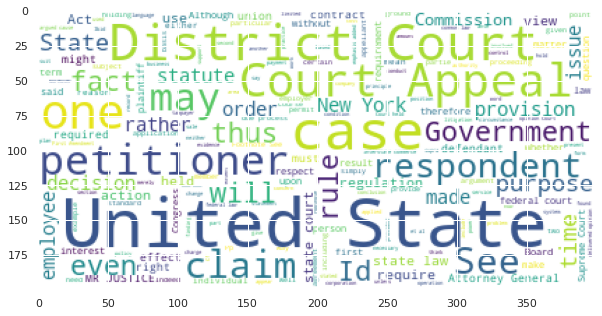

In [ ]:
generate_word_cloud(scotus_text)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


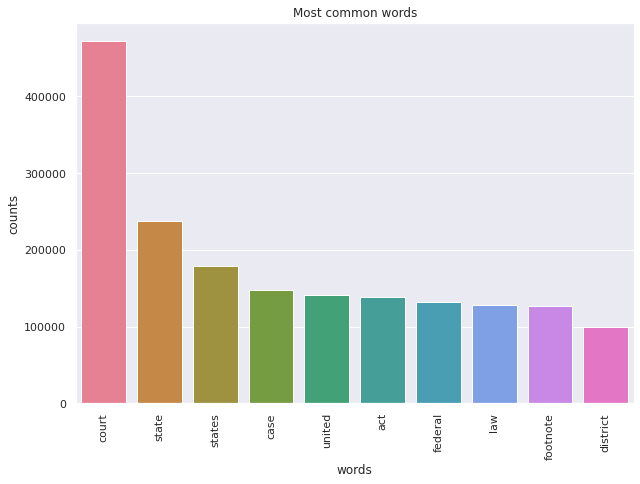

In [ ]:
most_common_words(scotus_text)

In [ ]:
X = np.array([d2v_model.docvecs[str(i)] for i in range(len(scotus_text))])
y = np.array(scotus_issue_area)

In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

Naive Bayes Classifier validation Score ->  62.351190476190474


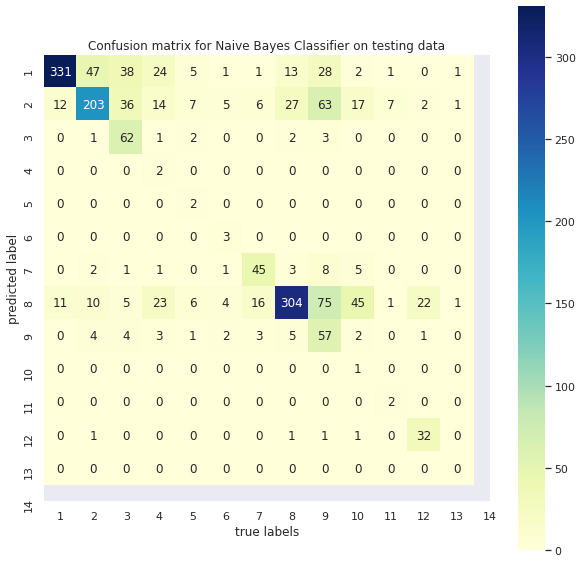

Naive Bayes Classifier test Score ->  62.142857142857146
Classification report for Naive Bayes Classifier on testing data:
              precision    recall  f1-score   support

           1       0.67      0.94      0.78       354
           2       0.51      0.76      0.61       268
           3       0.87      0.42      0.57       146
           4       1.00      0.03      0.06        68
           5       1.00      0.09      0.16        23
           6       1.00      0.19      0.32        16
           7       0.68      0.63      0.66        71
           8       0.58      0.86      0.69       355
           9       0.70      0.24      0.36       235
          10       1.00      0.01      0.03        73
          11       1.00      0.18      0.31        11
          12       0.89      0.56      0.69        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.62      0.62      0.62      1680
   macro av

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_naive_bayes(X_train, y_train, X_val, y_val)
scotus_naive_bayes(X_train, y_train, X_test, y_test, val=False)

Logistic Regression validation Score ->  67.55952380952381


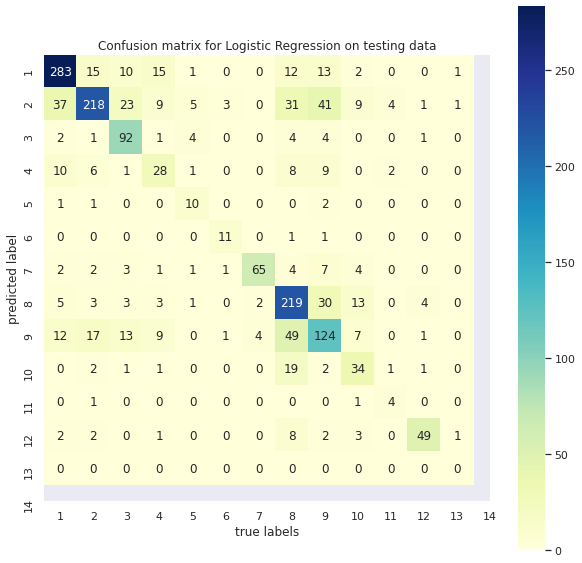

Logistic Regression test Score ->  67.67857142857143
Classification report for Logistic Regression on testing data:
              precision    recall  f1-score   support

           1       0.80      0.80      0.80       354
           2       0.57      0.81      0.67       268
           3       0.84      0.63      0.72       146
           4       0.43      0.41      0.42        68
           5       0.71      0.43      0.54        23
           6       0.85      0.69      0.76        16
           7       0.72      0.92      0.81        71
           8       0.77      0.62      0.69       355
           9       0.52      0.53      0.53       235
          10       0.56      0.47      0.51        73
          11       0.67      0.36      0.47        11
          12       0.72      0.86      0.78        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.68      0.68      0.68      1680
   macro avg      

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_logistic_regresiion(X_train, y_train, X_val, y_val)
scotus_logistic_regresiion(X_train, y_train, X_test, y_test, val=False)

Random Forest Classifier validation Score ->  52.45535714285714


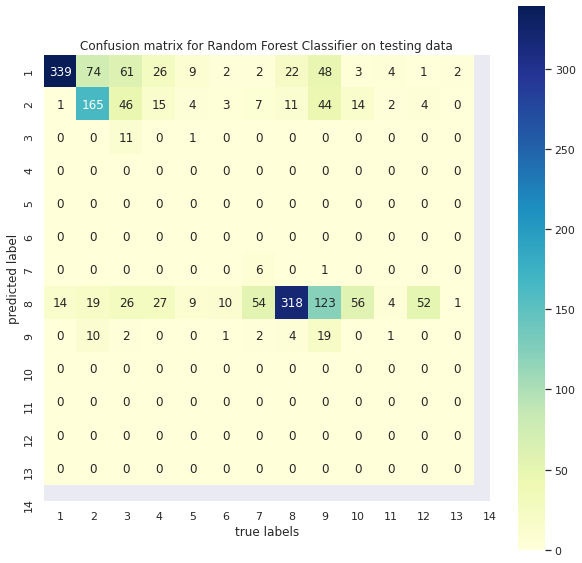

Random Forest Classifier test Score ->  51.07142857142857
Classification report for Random Forest Classifier on testing data:
              precision    recall  f1-score   support

           1       0.57      0.96      0.72       354
           2       0.52      0.62      0.57       268
           3       0.92      0.08      0.14       146
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        23
           6       1.00      0.00      0.00        16
           7       0.86      0.08      0.15        71
           8       0.45      0.90      0.60       355
           9       0.49      0.08      0.14       235
          10       1.00      0.00      0.00        73
          11       1.00      0.00      0.00        11
          12       1.00      0.00      0.00        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.51      0.51      0.51      1680
   macro

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_rf(X_train, y_train, X_val, y_val)
scotus_rf(X_train, y_train, X_test, y_test, val=False)

SVM validation Score ->  66.22023809523809


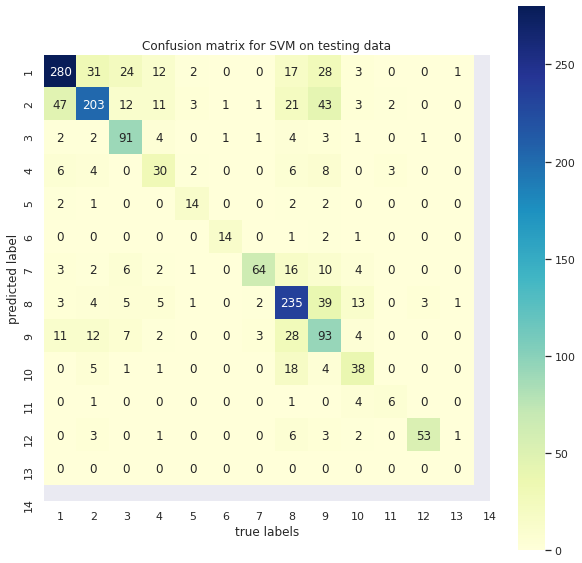

SVM test Score ->  66.72619047619047
Classification report for SVM on testing data:
              precision    recall  f1-score   support

           1       0.70      0.79      0.74       354
           2       0.59      0.76      0.66       268
           3       0.83      0.62      0.71       146
           4       0.51      0.44      0.47        68
           5       0.67      0.61      0.64        23
           6       0.78      0.88      0.82        16
           7       0.59      0.90      0.72        71
           8       0.76      0.66      0.71       355
           9       0.58      0.40      0.47       235
          10       0.57      0.52      0.54        73
          11       0.50      0.55      0.52        11
          12       0.77      0.93      0.84        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.67      0.67      0.67      1680
   macro avg       0.70      0.65      0.63      1

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_svm(X_train, y_train, X_val, y_val)
scotus_svm(X_train, y_train, X_test, y_test, val=False)